[*********************100%***********************]  1 of 1 completed


Epoch [50/1000], Loss: 0.0025
Epoch [100/1000], Loss: 0.0005
Epoch [150/1000], Loss: 0.0004
Epoch [200/1000], Loss: 0.0004
Epoch [250/1000], Loss: 0.0003
Epoch [300/1000], Loss: 0.0003
Epoch [350/1000], Loss: 0.0003
Epoch [400/1000], Loss: 0.0003
Epoch [450/1000], Loss: 0.0003
Epoch [500/1000], Loss: 0.0002
Epoch [550/1000], Loss: 0.0002
Epoch [600/1000], Loss: 0.0002
Epoch [650/1000], Loss: 0.0002
Epoch [700/1000], Loss: 0.0002
Epoch [750/1000], Loss: 0.0002
Epoch [800/1000], Loss: 0.0002
Epoch [850/1000], Loss: 0.0002
Epoch [900/1000], Loss: 0.0002
Epoch [950/1000], Loss: 0.0017
Epoch [1000/1000], Loss: 0.0002
LSTM Prediction vs Actual: [183.12544 183.7874  184.36523 184.08203 184.1535 ] [184.03506 185.0788  184.48238 184.81041 182.53409]
LR Prediction vs Actual: [184.14284 184.07784 184.96284 184.49944 184.5868 ] [184.03506 185.0788  184.48238 184.81041 182.53409]
LSTM MSE: 13.1704
LSTM RMSE: 3.6291
Linear Regression MSE: 8.7383
Linear Regression RMSE: 2.9561


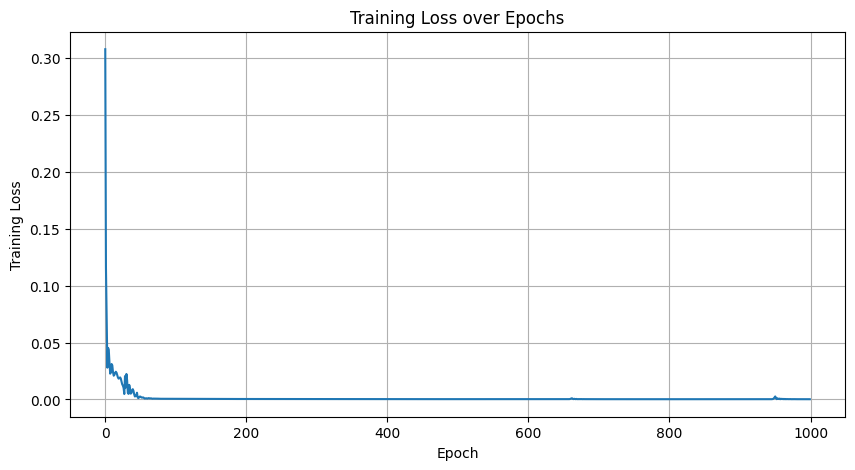

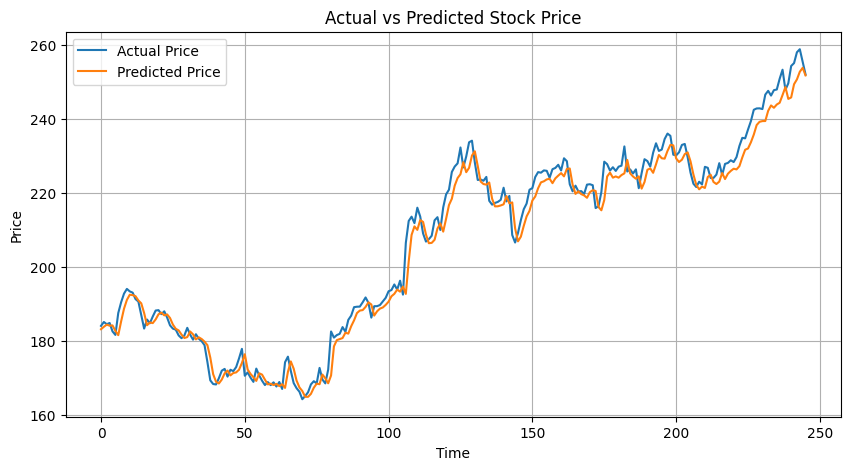

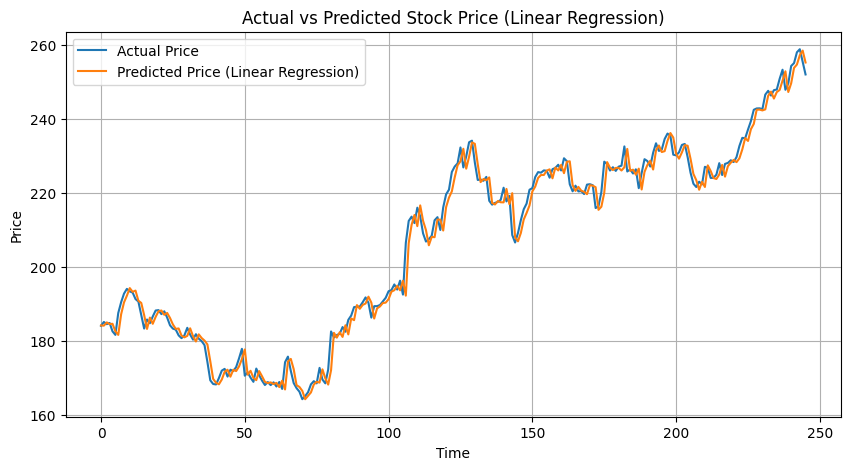

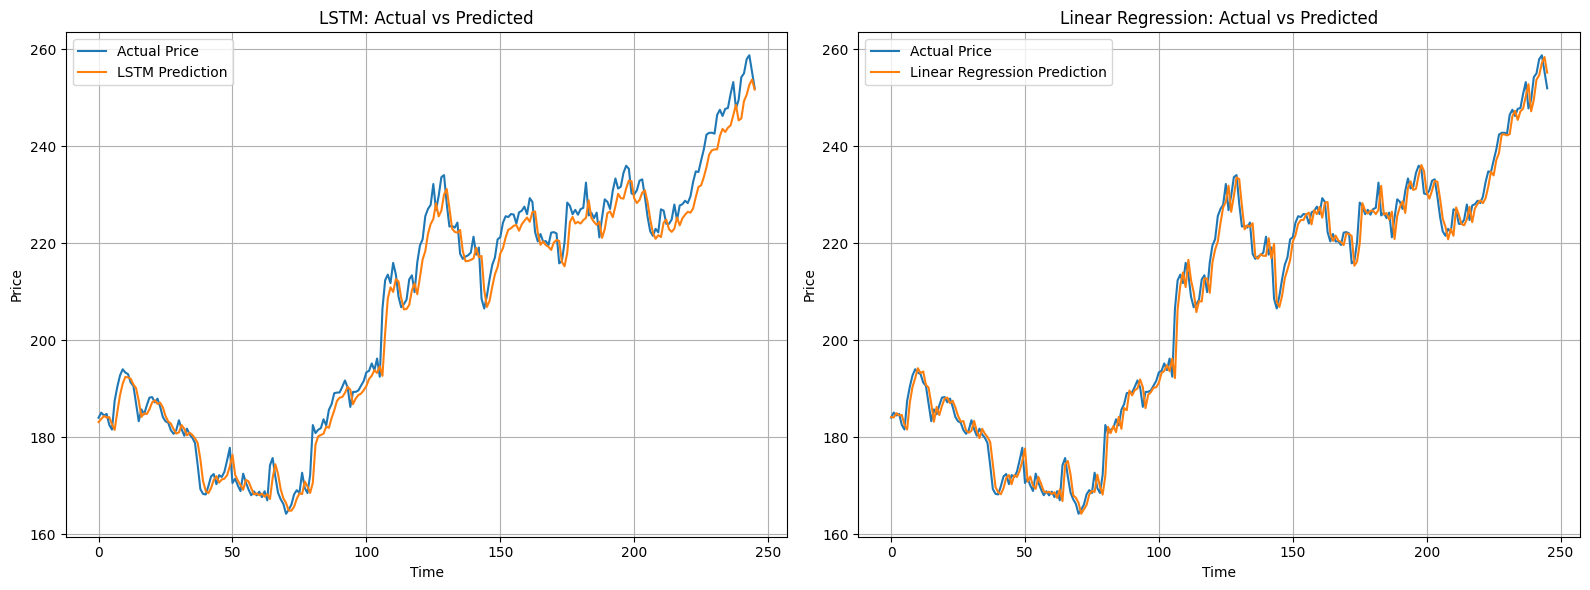


--- Future Price Predictions (Next 30 Trading Days) ---
            Predicted_Price
2024-12-31       249.010269
2025-01-01       246.665421
2025-01-02       244.674866
2025-01-03       242.897995
2025-01-06       241.254288
2025-01-07       239.703796
2025-01-08       238.224884
2025-01-09       236.804825
2025-01-10       235.435974
2025-01-13       234.113388
2025-01-14       232.833588
2025-01-15       231.593948
2025-01-16       230.392105
2025-01-17       229.226074
2025-01-20       228.094009
2025-01-21       226.994156
2025-01-22       225.924866
2025-01-23       224.884689
2025-01-24       223.872208
2025-01-27       222.886063
2025-01-28       221.925079
2025-01-29       220.988083
2025-01-30       220.074005
2025-01-31       219.181839
2025-02-03       218.310669
2025-02-04       217.459564
2025-02-05       216.627670
2025-02-06       215.814270
2025-02-07       215.018570
2025-02-10       214.239883


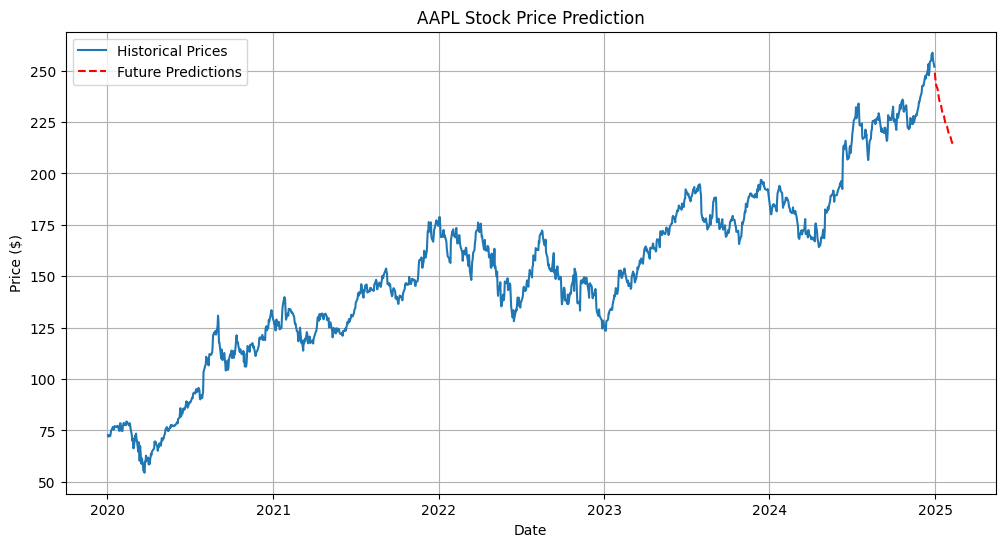

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import math
from sklearn.linear_model import LinearRegression
from datetime import datetime, timedelta


ticker = 'AAPL'
data = yf.download(ticker, start='2020-01-01', end='2024-12-31')


close_prices = data['Close'].values.reshape(-1, 1)


scaler = MinMaxScaler()
scaled_close = scaler.fit_transform(close_prices)


def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 30 
X, y = create_sequences(scaled_close, seq_length)


X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)


X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()


class StockPriceLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, output_size=1):
        super(StockPriceLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :]) 
        return out

model = StockPriceLSTM()


criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
epochs = 1000

train_losses = []


for epoch in range(epochs):
    model.train()
    output = model(X_train)
    loss = criterion(output, y_train)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    train_losses.append(loss.item())
    
    if (epoch+1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')


model.eval()
with torch.no_grad():
    predictions = model(X_test).detach().numpy()


X_train_lr = X_train.numpy().reshape(X_train.shape[0], X_train.shape[1])
X_test_lr = X_test.numpy().reshape(X_test.shape[0], X_test.shape[1])
naive_predictions = X_test[:, -1, 0].numpy().reshape(-1, 1)  

lr_model = LinearRegression()
lr_model.fit(X_train_lr, y_train.numpy())

lr_predictions = lr_model.predict(X_test_lr)



predicted_prices = scaler.inverse_transform(predictions)
actual_prices = scaler.inverse_transform(y_test.detach().numpy())

lr_predicted_prices = scaler.inverse_transform(lr_predictions)
lr_actual_prices = scaler.inverse_transform(y_test.numpy())

mse = mean_squared_error(actual_prices, predicted_prices)
rmse = math.sqrt(mse)

lr_mse = mean_squared_error(lr_actual_prices, lr_predicted_prices)
lr_rmse = math.sqrt(lr_mse)

print("LSTM Prediction vs Actual:", predicted_prices[:5].flatten(), actual_prices[:5].flatten())
print("LR Prediction vs Actual:", lr_predicted_prices[:5].flatten(), lr_actual_prices[:5].flatten())

print(f'LSTM MSE: {mse:.4f}')
print(f'LSTM RMSE: {rmse:.4f}')
print(f'Linear Regression MSE: {lr_mse:.4f}')
print(f'Linear Regression RMSE: {lr_rmse:.4f}')


plt.figure(figsize=(10,5))
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss over Epochs')
plt.grid(True)
plt.show()


plt.figure(figsize=(10,5))
plt.plot(actual_prices, label='Actual Price')
plt.plot(predicted_prices, label='Predicted Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs Predicted Stock Price')
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(10,5))
plt.plot(lr_actual_prices, label='Actual Price')
plt.plot(lr_predicted_prices, label='Predicted Price (Linear Regression)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs Predicted Stock Price (Linear Regression)')
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(16, 6))


plt.subplot(1, 2, 1)
plt.plot(actual_prices, label='Actual Price')
plt.plot(predicted_prices, label='LSTM Prediction')
plt.title('LSTM: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)


plt.subplot(1, 2, 2)
plt.plot(lr_actual_prices, label='Actual Price')
plt.plot(lr_predicted_prices, label='Linear Regression Prediction')
plt.title('Linear Regression: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


future_days = 30

last_sequence = scaled_close[-seq_length:].reshape(1, seq_length, 1)
last_sequence_tensor = torch.from_numpy(last_sequence).float()

future_predictions = []
future_dates = []
current_date = data.index[-1]

current_sequence = last_sequence.copy()

model.eval()
with torch.no_grad():
    
    for i in range(future_days):
        
        current_tensor = torch.from_numpy(current_sequence).float()
        
       
        pred = model(current_tensor).detach().numpy()
        future_predictions.append(pred[0, 0])
        
        
        current_sequence = np.roll(current_sequence, -1, axis=1)
        current_sequence[0, -1, 0] = pred[0, 0]
        
        
        current_date += timedelta(days=1)
        
        while current_date.weekday() > 4:  
            current_date += timedelta(days=1)
        future_dates.append(current_date)


future_prices = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))


future_df = pd.DataFrame(index=future_dates)
future_df['Predicted_Price'] = future_prices

print("\n--- Future Price Predictions (Next 30 Trading Days) ---")
print(future_df)


plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Close'], label='Historical Prices')
plt.plot(future_df.index, future_df['Predicted_Price'], 'r--', label='Future Predictions')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.title(f'{ticker} Stock Price Prediction')
plt.legend()
plt.grid(True)
plt.show()
